In [44]:
import numpy as np
import pandas
import torch
import neuralnetworks_torch as nntorch
import os
import time
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import scipy
from scipy.spatial.distance import cosine as cos_dist

In [45]:
class CNN1D(torch.nn.Module):

    def __init__(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_channels, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer,
                                n_outputs, patch_size_per_conv_layer, stride_per_conv_layer):
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = n_channels
        input_hw = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            print(input_hw,patch_size,stride,conv_layer_output_hw)
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        
        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

In [46]:
def pad(data):
    eps = np.unique(data[:,0])
    samples = data
    padded = samples.copy()
    for i in eps:
        count = np.count_nonzero(samples[:,0] == i)
        if count < 10:
            max_idx = np.max(np.where(padded[:,0] == i)[0])
            #print(i,10-count,max_idx)
            for j in range(10-count):
                #print("Inserting %s at %s" % (padded[max_idx][0], max_idx+1+j))
                padded = np.insert(padded,max_idx+1+j,padded[max_idx],axis=0)
                #print(j,padded.shape)
                
    return padded

In [47]:
def make_train_test_data(classes, crop_len, feature_idxs):
    subset = crop_len

    Xtrain = np.vstack([train_data[c][:subset] for c in classes])[:,feature_idxs]
    Ttrain = np.vstack([train_data[c][:subset] for c in classes])[:,1]
    Xtrain = Xtrain.reshape(Xtrain.shape[0],-1)

    Xtest = np.vstack([test_data[c] for c in classes])[:,feature_idxs]
    Ttest = np.vstack([test_data[c] for c in classes])[:,1]

    n_channels = Xtrain.shape[1]
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.flatten().reshape(-1,int(Xtrain.shape[1]*10)) # group into 10s
    Ttrain = np.max(Ttrain.flatten().reshape(-1,10), axis=1)

    Xtest = Xtest.flatten().reshape(-1,int(Xtest.shape[1]*10))
    Ttest = np.max(Ttest.flatten().reshape(-1,10), axis=1)
    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    Xtrain = Xtrain.reshape(-1,1,n_channels*10)
    Xtest = Xtest.reshape(-1,1,n_channels*10)

    print(Xtrain.shape,Ttrain.shape,Xtest.shape,Ttest.shape)

    return Xtrain,Ttrain,Xtest,Ttest

In [48]:
def train_classifier(X, T, n_classes, pretrained=None):
    gpu = True
    device = 'cpu'
    if gpu:
        if not torch.cuda.is_available():
            print("CUDA not available. Defaulting to CPU.")
        else:
            device = 'cuda:0'

    n_channels = X.shape[-1]//10
    
    cnn1d = CNN1D(n_channels*10, 1, [256, 128], [64, 64], n_classes, [n_channels, 4], [8, 2], device=device)
    
    #print(cnn1d.fc_layers[0].weight)
    
    if pretrained is not None:
        with torch.no_grad():
            for i in range(len(pretrained[0])):
                #print("Replacing %s with %s" % (cnn1d.conv_layers[i].weight,\
                #                                torch.nn.Parameter(pretrained[0][i])))
                cnn1d.conv_layers[i].weight = torch.nn.Parameter(pretrained[0][i])
            for i in range(len(pretrained[1])):
                #print("Replacing %s with %s" % (cnn1d.fc_layers[i].weight,\
                #                                torch.nn.Parameter(pretrained[1][i])))
                cnn1d.fc_layers[i].weight = torch.nn.Parameter(pretrained[1][i])

    n_epochs = 500
    batch_size = 100
    learning_rate = 0.001

    cnn1d.train(X, T, batch_size, n_epochs, learning_rate, method='adam')
    
    #print(cnn1d.fc_layers[0].weight)
    
    return cnn1d

In [49]:
# load up data
data = {}
data[0] = pandas.read_csv('trial-data/122921-2cubes.csv', header=None)
data[0] = data[0][data[0].iloc[:,1] == 0]

data[1] = pandas.read_csv('trial-data/122921-cube_sphere.csv', header=None)
data[1] = data[1][data[1].iloc[:,1] == 1]

data[2] = pandas.read_csv('trial-data/122921-cube_cylinder.csv', header=None)
data[2] = data[2][data[2].iloc[:,1] == 2]

data[3] = pandas.read_csv('trial-data/122921-cube_capsule.csv', header=None)
data[3] = data[3][data[3].iloc[:,1] == 3]

data[4] = pandas.read_csv('trial-data/122921-bigcube_smallcube.csv', header=None)
data[4] = data[4][data[4].iloc[:,1] == 4]

In [50]:
# pad data
padded_data = {}
padded_data[0] = pad(data[0].to_numpy())
padded_data[1] = pad(data[1].to_numpy())
padded_data[2] = pad(data[2].to_numpy())
padded_data[3] = pad(data[3].to_numpy())
padded_data[4] = pad(data[4].to_numpy())

test_n = 100 # 100 test samples of each class

# split train and test
test_data = {}
test_data[0] = padded_data[0][-test_n:]
test_data[1] = padded_data[1][-test_n:]
test_data[2] = padded_data[2][-test_n:]
test_data[3] = padded_data[3][-test_n:]
test_data[4] = padded_data[4][-test_n:]

crop_len = min([len(padded_data[k]) for k in padded_data])-test_n

print(crop_len)

train_data = {}
train_data[0] = padded_data[0][:crop_len]
train_data[1] = padded_data[1][:crop_len]
train_data[2] = padded_data[2][:crop_len]
train_data[3] = padded_data[3][:crop_len]
train_data[4] = padded_data[4][:crop_len]

for k in train_data:
    print(train_data[k].shape,train_data[k])

900
(900, 28) [[   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 [   3.    0.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]
 [  92.    0.    0. ... 1000. 1000. 1000.]]
(900, 28) [[ 3.        1.        0.       ...  9.        9.        9.      ]
 [ 3.        1.        0.       ...  9.       18.        9.      ]
 [ 3.        1.        0.       ... -1.       17.        5.666667]
 ...
 [92.        1.        0.       ...  9.       62.        7.75    ]
 [92.        1.        0.       ... -1.       61.        6.777778]
 [92.        1.        0.       ... -1.       60.        6.      ]]
(900, 28) [[   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 [   3.    2.    0. ... 1000. 1000. 1000.]
 ...
 [  92.    2.    0. ...  800.  798.  266.]
 [  92.    2.    0. ...  800.  798.  266.]
 [  92.    2.    0. ...  800.  798.  266.]]
(900, 28) [[ 3.        3.     

(1800, 19) (1800,) (200, 19) (200,)
(180, 190) (180,) (20, 190) (20,)
(180, 1, 190) (180,) (20, 1, 190) (20,)

CUDA not available. Defaulting to CPU.
190 19 8 22
22 4 2 10
adam: Epoch 50 Loss 0.001
adam: Epoch 100 Loss 0.001
adam: Epoch 150 Loss 0.000
adam: Epoch 200 Loss 0.000
adam: Epoch 250 Loss 0.000
adam: Epoch 300 Loss 0.000
adam: Epoch 350 Loss 0.000
adam: Epoch 400 Loss 0.000
adam: Epoch 450 Loss 0.000
adam: Epoch 500 Loss 0.000



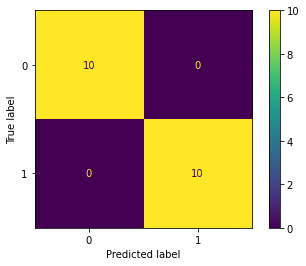

In [51]:
feature_idxs = [*range(3,16),*range(22,28)] 
#feature_idxs = [*range(3,13),*range(22,28)] # without jitter force
#feature_idxs = [*range(3,19),*range(22,28)] # with object position
Xtrain, Ttrain, Xtest, Ttest = make_train_test_data([0,1], crop_len, feature_idxs)
print()

model = train_classifier(Xtrain, Ttrain, 2)
print()

# check classifier on the test data
classes, probs = model.use(Xtest)

# make confusion matrix
cm = sklearn.metrics.confusion_matrix(Ttest, classes)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

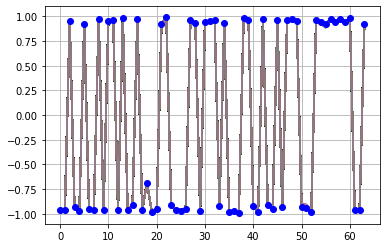

In [52]:
features = np.vstack([padded_data[0][100:]])[:,feature_idxs]
features = features.flatten().reshape(-1,int(features.shape[1]*10))
features = features.reshape(-1,1,19*10)
        
Ys = model.forward_all_outputs(torch.from_numpy(features).float())
logits = Ys[-2].detach().numpy()

cubes = []
for i in range(len(logits)):
    if cos_dist(np.mean(logits, axis=0),logits[i])/\
        cos_dist(np.mean(logits, axis=0),np.mean(logits, axis=0)+np.std(logits, axis=0)) < 1:
        cubes.append(logits[i])

plt.grid(True)
plt.ylim((-1.1,1.1))
_ = plt.plot(np.array(cubes).T)
_ = plt.plot(np.mean(np.array(cubes),axis=0).T,'bo')

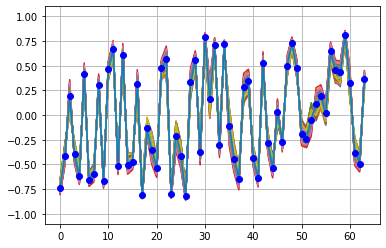

In [53]:
features = np.vstack([padded_data[1][100:]])[:,feature_idxs]
features = features.flatten().reshape(-1,int(features.shape[1]*10))
features = features.reshape(-1,1,19*10)
        
Ys = model.forward_all_outputs(torch.from_numpy(features).float())
logits = Ys[-2].detach().numpy()

spheres = []
for i in range(len(logits)):
    if cos_dist(np.mean(logits, axis=0),logits[i])/\
        cos_dist(np.mean(logits, axis=0),np.mean(logits, axis=0)+np.std(logits, axis=0)) < 1:
        spheres.append(logits[i])

plt.grid(True)
plt.ylim((-1.1,1.1))
_ = plt.plot(np.array(spheres).T)
_ = plt.plot(np.mean(np.array(spheres),axis=0).T,'bo')

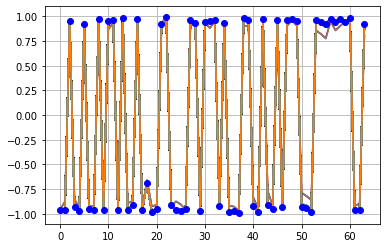

In [54]:
features = np.vstack([padded_data[2][100:]])[:,feature_idxs]
features = features.flatten().reshape(-1,int(features.shape[1]*10))
features = features.reshape(-1,1,19*10)
        
Ys = model.forward_all_outputs(torch.from_numpy(features).float())
logits = Ys[-2].detach().numpy()

cylinders = []
for i in range(len(logits)):
    if cos_dist(np.mean(logits, axis=0),logits[i])/\
        cos_dist(np.mean(logits, axis=0),np.mean(logits, axis=0)+np.std(logits, axis=0)) < 1:
        cylinders.append(logits[i])

plt.grid(True)
plt.ylim((-1.1,1.1))
_ = plt.plot(np.array(cylinders).T)
_ = plt.plot(np.mean(np.array(cylinders),axis=0).T,'bo')

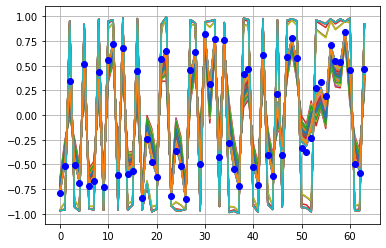

In [55]:
features = np.vstack([padded_data[3][100:]])[:,feature_idxs]
features = features.flatten().reshape(-1,int(features.shape[1]*10))
features = features.reshape(-1,1,19*10)
        
Ys = model.forward_all_outputs(torch.from_numpy(features).float())
logits = Ys[-2].detach().numpy()

capsules = []
for i in range(len(logits)):
    if cos_dist(np.mean(logits, axis=0),logits[i])/\
        cos_dist(np.mean(logits, axis=0),np.mean(logits, axis=0)+np.std(logits, axis=0)) < 1:
        capsules.append(logits[i])

plt.grid(True)
plt.ylim((-1.1,1.1))
_ = plt.plot(np.array(capsules).T)
_ = plt.plot(np.mean(np.array(capsules),axis=0).T,'bo')

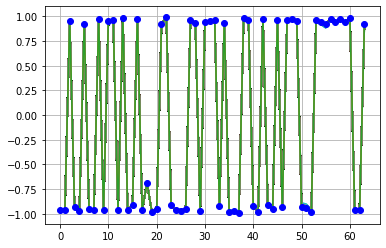

In [56]:
features = np.vstack([padded_data[4][100:]])[:,feature_idxs]
features = features.flatten().reshape(-1,int(features.shape[1]*10))
features = features.reshape(-1,1,19*10)
        
Ys = model.forward_all_outputs(torch.from_numpy(features).float())
logits = Ys[-2].detach().numpy()

small_cubes = []
for i in range(len(logits)):
    if cos_dist(np.mean(logits, axis=0),logits[i])/\
        cos_dist(np.mean(logits, axis=0),np.mean(logits, axis=0)+np.std(logits, axis=0)) < 1:
        small_cubes.append(logits[i])

plt.grid(True)
plt.ylim((-1.1,1.1))
_ = plt.plot(np.array(small_cubes).T)
_ = plt.plot(np.mean(np.array(small_cubes),axis=0).T,'bo')

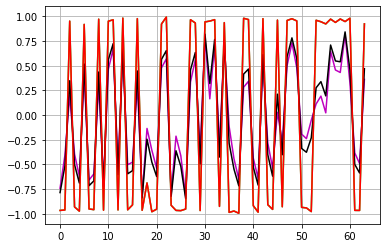

In [57]:
plt.grid(True)
plt.ylim((-1.1,1.1))
_ = plt.plot(np.mean(np.array(cubes),axis=0).T,'c')
_ = plt.plot(np.mean(np.array(spheres),axis=0).T,'m')
_ = plt.plot(np.mean(np.array(cylinders),axis=0).T,'y')
_ = plt.plot(np.mean(np.array(capsules),axis=0).T,'k')
_ = plt.plot(np.mean(np.array(small_cubes),axis=0).T,'r')

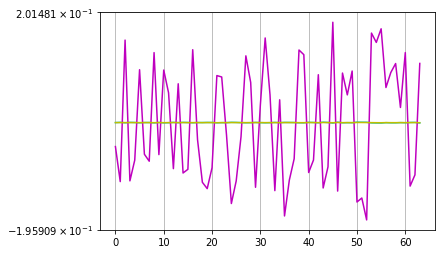

In [59]:
plt.grid(True)
plt.yscale('symlog')
#plt.ylim((-1.1,1.1))
_ = plt.plot(np.mean(np.array(cylinders),axis=0)-np.mean(np.array(cubes),axis=0).T,'c')
_ = plt.plot(np.mean(np.array(capsules),axis=0)-np.mean(np.array(spheres),axis=0).T,'m')
_ = plt.plot(np.mean(np.array(small_cubes),axis=0)-np.mean(np.array(cubes),axis=0).T,'y')

[0.22439432 0.5505773  0.7540175  0.53500926 0.35285068 0.49787262
 0.29325837 0.36153167 0.6625252  0.29804814 0.4864519  0.295116
 0.44115233 0.3717926  0.45680326 0.43185386 0.6627619  0.15719002
 0.55152786 0.6230992  0.41284943 0.44411534 0.42283964 0.11458021
 0.7513275  0.55510104 0.13161689 0.6306683  0.37170506 0.58958346
 0.15625083 0.78665173 0.25159943 0.6237758  0.21943653 0.8694483
 0.52914894 0.34372783 0.69751203 0.62488496 0.48109427 0.34267443
 0.45145327 0.62508404 0.41727513 0.93361515 0.6516837  0.45614654
 0.24448967 0.4740741  0.74167204 0.70107156 0.9239999  0.84708655
 0.752647   0.89990515 0.32653308 0.48142025 0.5412658  0.13256705
 0.6508596  0.5813744  0.47482288 0.56162244]
[45 52 55 35 53] [0.93361515 0.9239999  0.89990515 0.8694483  0.84708655]


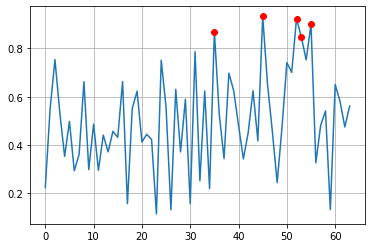

In [60]:
diff = np.mean(np.array(spheres),axis=0)-np.mean(np.array(cubes),axis=0)
print(np.abs(diff))
ind = np.flip(np.argpartition(np.abs(diff), -5)[-5:])
print(ind,np.abs(diff)[ind])

plt.grid(True)
#_ = plt.plot(diff.T,)
_ = plt.plot(np.abs(diff).T)
_ = plt.plot(ind,np.abs(diff)[ind].T,'ro')

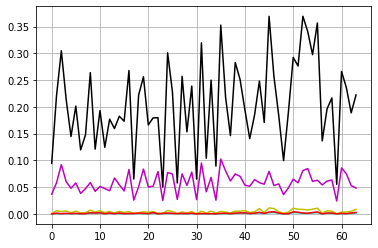

In [76]:
plt.grid(True)
#plt.ylim((-1.1,1.1))
_ = plt.plot(np.std(np.array(cubes),axis=0).T,'c')
_ = plt.plot(np.std(np.array(spheres),axis=0).T,'m')
_ = plt.plot(np.std(np.array(cylinders),axis=0).T,'y')
_ = plt.plot(np.std(np.array(capsules),axis=0).T,'k')
_ = plt.plot(np.std(np.array(small_cubes),axis=0).T,'r')

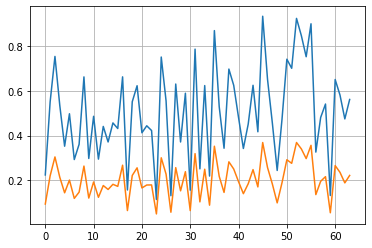

In [77]:
plt.grid(True)
_ = plt.plot(np.abs(diff).T)
_ = plt.plot(np.std(np.array(capsules),axis=0).T)

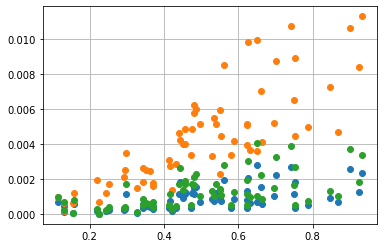

In [96]:
plt.grid(True)
_ = plt.plot(np.abs(diff).T,np.std(np.array(cubes),axis=0).T,'o')
_ = plt.plot(np.abs(diff).T,np.std(np.array(cylinders),axis=0).T,'o')
_ = plt.plot(np.abs(diff).T,np.std(np.array(small_cubes),axis=0).T,'o')

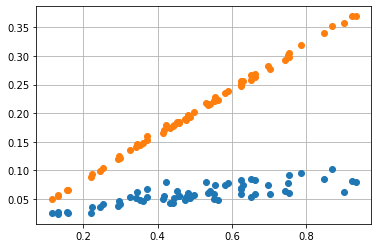

In [97]:
plt.grid(True)
_ = plt.plot(np.abs(diff).T,np.std(np.array(spheres),axis=0).T,'o')
_ = plt.plot(np.abs(diff).T,np.std(np.array(capsules),axis=0).T,'o')

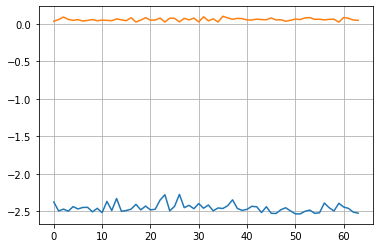

In [80]:
plt.grid(True)
_ = plt.plot(-np.abs(diff)/np.std(np.array(capsules),axis=0).T)
_ = plt.plot(np.std(np.array(spheres),axis=0).T)

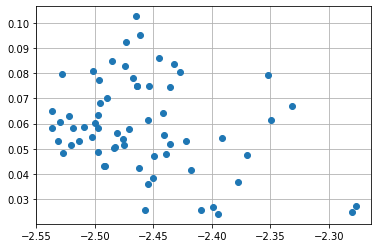

In [81]:
plt.grid(True)
_ = plt.plot(-np.abs(diff)/np.std(np.array(capsules),axis=0).T,
             np.std(np.array(spheres),axis=0).T,'o')